# HOST

**Author:** _Matteo Bagagli_ - **Date:** _10/2021_ - **Version:** _2.4.2_

-------------------------------------------------------------------------------------------------------------------

The **HOST** acronym stands for **H**igh-**O**rder-**ST**atistics seismic pickers.
This algorithm took inspiration from the one described in [_Baillard et al. 2014_](10.1785/0120120347). 
The idea behing this package is to provide user-friendly classes for seismic phase picking with _skewness_ and _kurtosis_ carachteristic-functions. I

Originally applied to seismograms by [_Saragiotis et al._](10.1109/TGRS.2002.800438), the HOS-CF are able to detect energic transient when the statistical properties of a seismogram (or time series) change abruptly. These CF are calculated on moving window with fixed window.

Measurements of statistical properties in a moving window are suitable for frequency-specific (or expected) transient. For this reason, the picker support a multi-window analysis, in order to collecto more information or even increase the quality of about 

Both _skewness_ and _kurtosis_ are calculated with C-routine under the hood, making this package fast and suitable also for realtime picking porpouses.

For the installation please refer to the `README.md` file in the project-home (for both standard and developer installation)


# Real-case scenario
-------------------------------------------------------

First, let's import the `ObsPy` library and the package main class `Host`. 
This time we also need to import the `scaffold` module, that contains all the necessary transformation.
This time the waveform loaded is already processed. This is a real case scenario with messy arrival ...

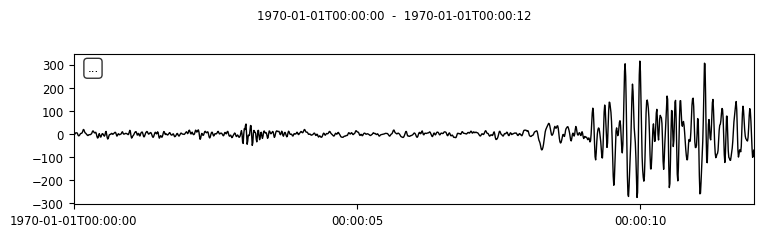

In [1]:
# ----------------------------------------  To work
import sys
import logging
from obspy import read, UTCDateTime
from host.picker import Host
from host.plotting import plot_HOST
from host import scaffold as HSC

# ----------------------------------------  To show and log
%matplotlib inline 
import matplotlib.pyplot as plt
logger = logging.getLogger()
logger.setLevel(logging.INFO)

tr = read("../tests_data/real_case.SAC")[0]
tr.plot();


Now we want to initialize the main picker object, by providing the processed trace and the time-window (in seconds) for the CF calculation, and the `hos_method`. For the porpouse of demonstration, we will use the `'kurt'` option ...

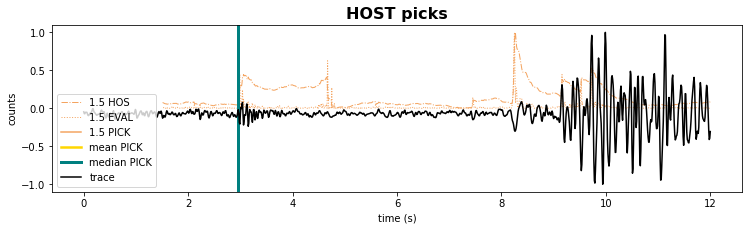

{'1.5': 1970-01-01T00:00:02.960000Z,
 'pick_error': 2.6899999999999999,
 'valid_obs': {'1.5': 1970-01-01T00:00:02.960000Z},
 'outlier_obs': {},
 'mean': 1970-01-01T00:00:02.960000Z,
 'median': 1970-01-01T00:00:02.960000Z}

In [2]:
HP = Host(tr, 1.5,  hos_method='kurtosis')  # also 'kurt' and 'k' works ...
HP.set_detection_method('diff')
HP.set_diffgauss_threshold(2)
HP.work(debug_plot=True)
HP.get_picks_UTC()

The small-signal around ~3 second from the start create already a significant variation in the _kurtosis_ function, disturbing the detection of the true onset.
So significant, that a simple threshold limiter (like the `diff` method) is unable to oversee.

Let's try to add some simple transformations ...

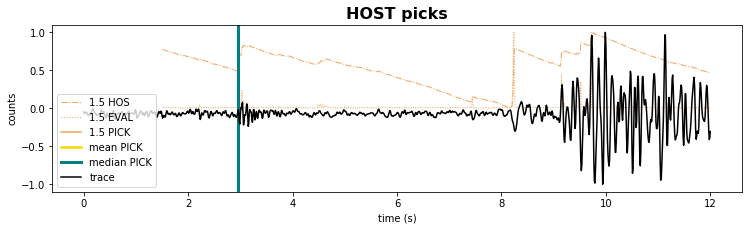

In [3]:
HP.set_transform_cf(
    {
        'transform_f2': {},  # this function is non-parametric
        'transform_f3': {}   # this function is non-parametric        
    }
)
HP.work(debug_plot=True)

Still, the detection method remain stuck on the first real variation of the signal. Indeed, the `diff` method, is sensitive to spikes and is suitable for real phase close-up rather than longer time window analysis. It's clear though, that the transformed, robust  HOST-CF is easy to detect with the `min` method ...

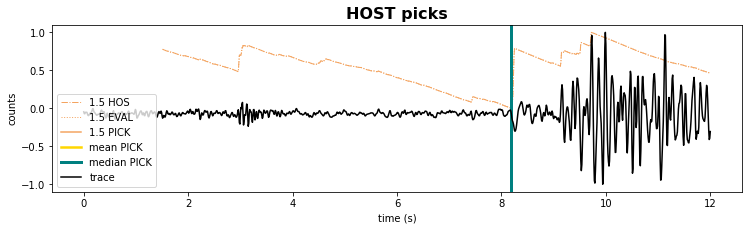

{'1.5': 1970-01-01T00:00:08.190000Z,
 'pick_error': 5.2800000000000002,
 'valid_obs': {'1.5': 1970-01-01T00:00:08.190000Z},
 'outlier_obs': {},
 'mean': 1970-01-01T00:00:08.190000Z,
 'median': 1970-01-01T00:00:08.190000Z}

In [4]:
HP.set_detection_method('min')
HP.work(debug_plot=True)
HP.get_picks_UTC()

# Multi-CF
-------------------------------------------------------

An additional powerful feature of this picker, is the ability to detect the arrival-time with a multi-CF analysis approach. Every `Host` class, in fact, could be either initialized with a single`float/int` or a `list/tuple` of numbers to specify the CF's creation window sizes.

If multiple time-window inserted, the code will apply the same _transformations_ and _detection-method_ to all the different HOST-CFs.

To declare the final pick, the algorithm automatically detect outliers and remove them from the observations pool, and estimate `mean/median` of the remaining valid observations distribution. This increase dramatically the pick-error assessment quality, as it is calculated as the seconds between the first and last valid observations.

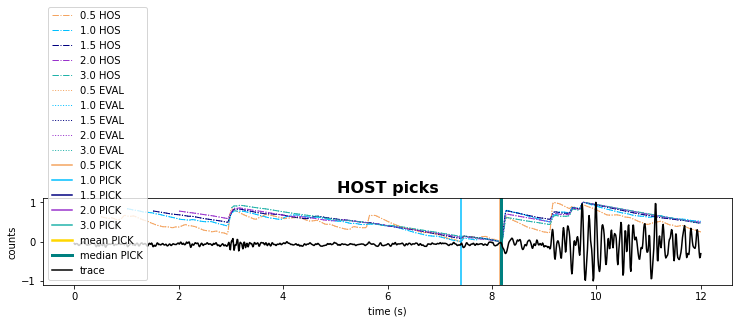

{'0.5': 1970-01-01T00:00:08.160000Z,
 '1.0': 1970-01-01T00:00:07.400000Z,
 '1.5': 1970-01-01T00:00:08.170000Z,
 '2.0': 1970-01-01T00:00:08.170000Z,
 '3.0': 1970-01-01T00:00:08.170000Z,
 'pick_error': 0.01,
 'valid_obs': {'0.5': 1970-01-01T00:00:08.160000Z,
  '1.5': 1970-01-01T00:00:08.170000Z,
  '2.0': 1970-01-01T00:00:08.170000Z,
  '3.0': 1970-01-01T00:00:08.170000Z},
 'outlier_obs': {'1.0': 1970-01-01T00:00:07.400000Z},
 'mean': 1970-01-01T00:00:08.167500Z,
 'median': 1970-01-01T00:00:08.170000Z}

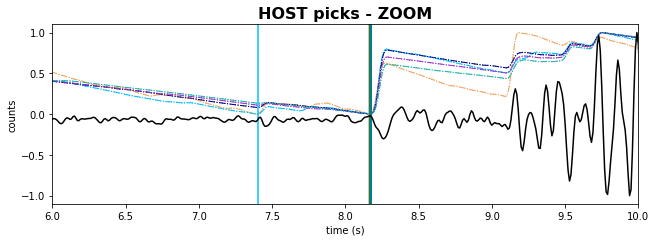

In [5]:
HP = Host(tr, [0.5, 1.0, 1.5, 2.0, 3.0],  hos_method='kurtosis')  # also 'kurt' and 'k' works ...
HP.set_detection_method('min')
HP.set_transform_cf(
    {
        'transform_f2': {},  # this function is non-parametric
        'transform_f3': {},   # this function is non-parametric 
        'transform_smooth_custom': {
            'smooth_win': 0.1}   # this function is non-parametric             
    }
)

HP.work(debug_plot=True)

# --- Zoom IN
(hfig, hax) = plot_HOST(
                HP,
                normalize=True,
                axtitle="HOST picks - ZOOM",
                shift_cf=False,
                debug_plot=True,
                plot_final_picks=True,
                show=False)
hax.get_legend().remove()
hax.set_xlim([6, 10])

# Extract results
HP.get_picks_UTC()

In this case, we see that the software correctly detects the outlier of `0.5 sec` thus providing the stable, bulk obserations pool at the correct onset.

Still in this case, the pick-error is 0 because all the CFs agrees. In other situation, different CF outcome for the same phase-detection may occur: the resulting plot will then show with a gray-band the pick-uncertainty.

### Error assessment
In case of a single-CF analysis (like in book 0-1-2), the **relative** pick-error will report the **signal-to-noise ratio** around the pick:
- _Signal value_: maximum amplitude in 1.0 sec window _after_ the pick
- _Noise value_: 2 times the standard deviation of a 1.0 sec window _before_ the pick

The user should then take care to define their own classification with this information

In case of mult-CF analysis, the **absolute** pick-error is the seconds between the first and last valid observations. The valid observation pool is defined by a Jack-Knife procedure, where it's evaluated the contribution of each individual pick to the stability of the entire observations distribution. If the _mean-bias_ exceed one standard deviation of the entire observations biases distribution, it is considered an _outlier_ and will not be further used.



Enjoy finding your own pipelines! And don't forget to check the last book if you want to implement your personal _transformation_ function!

### References
- Baillard, C., Crawford, W.C., Ballu, V., Hibert, C. and Mangeney, A., 2014. An automatic kurtosis‐based P‐and S‐phase picker designed for local seismic networks. Bulletin of the Seismological Society of America, 104(1), pp.394-409.
- Saragiotis, C.D., Hadjileontiadis, L.J. & Panas, S.M., 2002. PAI-S/K: a robust automatic seismic P phase arrival identification scheme, IEEE Trans. Geosci. Remote Sens. 40, 1395–1404.